In [1]:
!pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu118
!pip install transformers sentencepiece datasets evaluate optuna rouge_score sacrebleu

Looking in indexes: https://download.pytorch.org/whl/nightly/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.5 

In [2]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.optim import AdamW
from torch.nn import functional as F
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
import evaluate
load_metric = evaluate.load

sns.set()

/usr/local/lib/python3.11/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [25]:
model_repo = 'google/mt5-small'
model_path = '/content/gdrive/MyDrive/mt5_translation.pt'
reinforce_path = '/content/gdrive/MyDrive/mt5_reinforce.pt'
max_seq_len = 20

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

input_lang, target_lang = 'sentence_eng_Latn', 'sentence_ind_Latn'

LANG_TOKEN_MAPPING = {
    'sentence_eng_Latn': '<en>',
    'sentence_ind_Latn': '<id>'
}

special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))
model.load_state_dict(torch.load(model_path))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

<All keys matched successfully>

In [6]:
train_dataset = load_dataset('Muennighoff/flores200', 'eng_Latn-ind_Latn', split='dev', trust_remote_code=True)
test_dataset = load_dataset('Muennighoff/flores200', 'eng_Latn-ind_Latn', split='devtest', trust_remote_code=True)

README.md:   0%|          | 0.00/9.01k [00:00<?, ?B/s]

flores200.py:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

In [125]:
# Constants
n_epochs = 15
batch_size = 32
print_freq = 4
checkpoint_freq = 16
lr = 5e-6
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [8]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):

    # Get the translations for the batch
    input_text = translations[input_lang]
    target_text = translations[target_lang]

    if input_text is None or target_text is None:
        return None

    input_token_ids = encode_input_str(
        input_text, target_lang, tokenizer, seq_len, lang_token_map)

    target_token_ids = encode_target_str(
        target_text, tokenizer, seq_len, lang_token_map)

    return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
    raw_inputs  = batch[input_lang]
    raw_targets = batch[target_lang]
    batch = [
        {input_lang: raw_inputs[i], target_lang: raw_targets[i]}
        for i in range(len(raw_inputs))
    ]

    inputs = []
    targets = []
    for translation_set in batch:
        formatted_data = format_translation_data(
            translation_set, lang_token_map, tokenizer, max_seq_len)

        if formatted_data is None:
            continue

        input_ids, target_ids = formatted_data
        inputs.append(input_ids.unsqueeze(0))
        targets.append(target_ids.unsqueeze(0))

    batch_input_ids = torch.cat(inputs).cuda()
    batch_target_ids = torch.cat(targets).cuda()

    return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
    dataset = dataset.shuffle()
    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i+batch_size]
        yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [9]:
print(train_dataset[0])

{'id': 1, 'URL': 'https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet', 'domain': 'wikinews', 'topic': 'health', 'has_image': 0, 'has_hyperlink': 0, 'sentence_eng_Latn': 'On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.', 'sentence_ind_Latn': 'Ilmuwan dari Stanford University School of Medicine pada hari Senin mengumumkan penemuan alat diagnostik baru yang bisa mengurutkan sel berdasarkan tipe: cip kecil dapat dicetak yang bisa diproduksi menggunakan printer inkjet standar dengan biaya sekitar satu sen AS per cip.'}


In [10]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<id> ▁On ▁Monday , ▁ scientist s ▁from ▁the ▁ Stanford ▁University ▁School ▁of ▁Medicine ▁ announced ▁the ▁in vention ▁of ▁ a ▁new ▁diagnostic ▁tool ▁that ▁can ▁sort ▁ cells ▁by ▁type : ▁ a ▁ tiny ▁print able ▁chip ▁that ▁can ▁be ▁manufacture d ▁ using ▁standard ▁in k jet ▁printer s ▁for ▁possibl y ▁about ▁one ▁U . S . ▁cent ▁ each . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁Ilm uwan ▁dari ▁ Stanford ▁University ▁School ▁of ▁Medicine ▁pada ▁hari ▁Sen in ▁meng um umkan ▁pen emuan ▁alat ▁diagnostik ▁baru ▁yang ▁bisa ▁meng urut kan ▁sel ▁berda sarkan ▁ tipe : ▁ cip ▁kecil ▁dapat ▁dice tak ▁yang ▁bisa ▁di produksi ▁ menggunakan ▁printer ▁in k jet ▁standar ▁dengan ▁bi aya 

In [97]:
# -------------------- Metrics & Reward Function --------------------
bleu_metric = load_metric('sacrebleu')
rouge_metric = load_metric('rouge')
meteor_metric = load_metric('meteor')

# Weights for reward terms
LAMBDA_BLEU  = 0.4
LAMBDA_ROUGE = 0.3
LAMBDA_METEOR= 0.2
LAMBDA_REP   = 0.1

def compute_reward(preds, refs,
                   lambda_bleu=LAMBDA_BLEU,
                   lambda_rouge=LAMBDA_ROUGE,
                   lambda_meteor=LAMBDA_METEOR,
                   lambda_rep=LAMBDA_REP):
    # BLEU score
    bleu = bleu_metric.compute(predictions=preds, references=[[r] for r in refs])['score']
    # ROUGE-L F1 (scale to percentage)
    rouge_res = rouge_metric.compute(predictions=preds, references=refs, rouge_types=["rougeL"], use_stemmer=True)
    # Access the 'fmeasure' directly from rouge_res['rougeL'] for MT5
    rouge = rouge_res['rougeL'] * 100
    # METEOR (scale to percentage)
    meteor = meteor_metric.compute(predictions=preds, references=refs)['meteor'] * 100
    # Repetition penalty: avg token-duplication ratio per sentence (percentage)
    rep_scores = []
    for pred in preds:
        tokens = pred.split()
        if not tokens:
            rep_scores.append(0.0)
            continue
        dup = len(tokens) - len(set(tokens))
        rep_scores.append((dup / len(tokens)) * 100)
    rep_pen = sum(rep_scores) / len(rep_scores)
    # Combined reward
    return (lambda_bleu * bleu
            + lambda_rouge * rouge
            + lambda_meteor * meteor
            - lambda_rep * rep_pen)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
# Reset training
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [105]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.detach().item())

  return np.mean(eval_losses)

In [137]:
model.load_state_dict(torch.load(model_path))
losses = []
reward_history = []
baseline = 0.0
optimizer = AdamW(model.parameters(), lr=lr)

In [138]:
# Get test data
model.eval()
test_generator = get_data_generator(test_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size)
all_preds = []
all_refs = []

# Collect predictions and references
for input_batch, label_batch in test_generator:
    with torch.no_grad():
        model_out = model.generate(input_ids=input_batch)
    preds = tokenizer.batch_decode(model_out, skip_special_tokens=True)
    refs = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
    all_preds.extend(preds)
    all_refs.extend(refs)

# Store per-example scores
bleu_scores = []
rouge_scores = []
meteor_scores = []

for pred, ref in zip(all_preds, all_refs):
    # BLEU expects a list of references (even if it's just one)
    bleu = bleu_metric.compute(predictions=[pred], references=[[ref]])['score']
    rouge = rouge_metric.compute(predictions=[pred], references=[ref], rouge_types=["rougeL"], use_stemmer=True)['rougeL'] * 100
    meteor = meteor_metric.compute(predictions=[pred], references=[ref])['meteor'] * 100

    bleu_scores.append(bleu)
    rouge_scores.append(rouge)
    meteor_scores.append(meteor)

# Compute mean and standard deviation
print(f"BLEU Score: Mean = {np.mean(bleu_scores):.2f}, Std = {np.std(bleu_scores):.2f}, max = {np.max(bleu_scores):.2f}, min = {np.min(bleu_scores):.2f}")
print(f"ROUGE-L Score: Mean = {np.mean(rouge_scores):.2f}, Std = {np.std(rouge_scores):.2f}, max = {np.max(rouge_scores):.2f}, min = {np.min(rouge_scores):.2f}")
print(f"METEOR Score: Mean = {np.mean(meteor_scores):.2f}, Std = {np.std(meteor_scores):.2f}, max = {np.max(meteor_scores):.2f}, min = {np.min(meteor_scores):.2f}")

s_bleu_scores = bleu_scores[:]
s_rouge_scores = rouge_scores[:]
s_meteor_scores = meteor_scores[:]


BLEU Score: Mean = 17.65, Std = 15.68, max = 100.00, min = 0.00
ROUGE-L Score: Mean = 42.25, Std = 19.12, max = 100.00, min = 0.00
METEOR Score: Mean = 38.82, Std = 20.39, max = 99.99, min = 0.00


In [127]:
model.train()
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Set the model to evaluation mode for generation
    model.eval()

    with torch.no_grad():
        # Autoregressively sample output sequences from model
        generated_ids = model.generate(
            input_ids=input_batch,
            max_length=max_seq_len,             # pick a reasonable max length
            do_sample=True,                 # enables stochastic sampling
            temperature=1.0,                # controls randomness
            top_k=50,                       # or try top_p=0.95 (nucleus sampling)
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Back to training mode
    model.train()

    # Decode sampled outputs and reference labels
    preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    refs  = tokenizer.batch_decode(label_batch, skip_special_tokens=True)

    # === Step 1: Compute reward ===
    reward_value = compute_reward(preds, refs)  # This should return a scalar or tensor
    rewards = torch.full((input_batch.size(0),), reward_value, device='cuda')  # (batch,)

    # === Step 2: Compute log probs of sampled tokens ===
    # Shift input/output for causal LM (teacher forcing for log prob calculation)
    sampled_input = generated_ids[:, :-1]
    sampled_target = generated_ids[:, 1:]

    # Forward pass to get logits
    model_out = model(
        input_ids=input_batch,              # encoder inputs (e.g., the prompt)
        decoder_input_ids=sampled_input     # autoregressively sampled decoder inputs
    )

    logits = model_out.logits  # shape: (B, T, V)

    # Log probs over vocab
    log_probs = F.log_softmax(logits, dim=-1)

    # Gather log probs of sampled tokens
    log_probs_for_actions = log_probs.gather(
        -1, sampled_target.unsqueeze(-1)  # index shape: (B, T, 1)
    ).squeeze(-1)  # (B, T)

    # Sum over time to get total log prob for each sequence
    log_probs_sum = log_probs_for_actions.sum(dim=1)  # (B,)

    # Baseline subtraction
    baseline = 0.9 * baseline + 0.1 * rewards.mean().item()
    advantages = rewards - baseline
    # Loss
    loss = -(advantages.detach() * log_probs_sum).mean()

    loss.backward()
    optimizer.step()
    scheduler.step()

    losses.append(loss.detach().item())
    reward_history.append(reward_value)

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
        avg_loss = np.mean(losses[-print_freq:])
        print('Epoch: {} | Step: {} | Avg. loss: {:.8f}'.format(
            epoch_idx+1, batch_idx+1, avg_loss))

    if (batch_idx + 1) % checkpoint_freq == 0:
        print(eval_model(model, test_dataset))

<ipython-input-127-04c79175806d>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 | Step: 4 | Avg. loss: 2473.14312744
Epoch: 1 | Step: 8 | Avg. loss: 2064.46647644
Epoch: 1 | Step: 12 | Avg. loss: 1447.86596680
Epoch: 1 | Step: 16 | Avg. loss: 984.52709961
9.620957612991333
Epoch: 1 | Step: 20 | Avg. loss: 731.38689232
Epoch: 1 | Step: 24 | Avg. loss: 303.82995224
Epoch: 1 | Step: 28 | Avg. loss: -30.98027420
Epoch: 1 | Step: 32 | Avg. loss: 199.80178642
9.710575222969055


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 | Step: 4 | Avg. loss: 199.76063156
Epoch: 2 | Step: 8 | Avg. loss: 72.88107359
Epoch: 2 | Step: 12 | Avg. loss: -125.15450907
Epoch: 2 | Step: 16 | Avg. loss: 6.42406082
9.526600122451782
Epoch: 2 | Step: 20 | Avg. loss: 120.46240234
Epoch: 2 | Step: 24 | Avg. loss: -97.25371742
Epoch: 2 | Step: 28 | Avg. loss: -9.23275757
Epoch: 2 | Step: 32 | Avg. loss: 608.46961975
9.724331974983215


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 | Step: 4 | Avg. loss: -0.57448196
Epoch: 3 | Step: 8 | Avg. loss: -184.05729675
Epoch: 3 | Step: 12 | Avg. loss: -117.93326569
Epoch: 3 | Step: 16 | Avg. loss: -353.03473663
9.66272234916687
Epoch: 3 | Step: 20 | Avg. loss: 82.77615166
Epoch: 3 | Step: 24 | Avg. loss: 231.93865204
Epoch: 3 | Step: 28 | Avg. loss: -313.27819681
Epoch: 3 | Step: 32 | Avg. loss: -210.17952347
9.501372218132019


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 | Step: 4 | Avg. loss: 331.32228088
Epoch: 4 | Step: 8 | Avg. loss: -148.15939331
Epoch: 4 | Step: 12 | Avg. loss: 103.88597679
Epoch: 4 | Step: 16 | Avg. loss: 124.81633186
9.429619193077087
Epoch: 4 | Step: 20 | Avg. loss: 235.86817169
Epoch: 4 | Step: 24 | Avg. loss: -279.16193390
Epoch: 4 | Step: 28 | Avg. loss: -55.80740213
Epoch: 4 | Step: 32 | Avg. loss: 147.40234375
9.46546196937561


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 | Step: 4 | Avg. loss: -207.19963264
Epoch: 5 | Step: 8 | Avg. loss: -252.50392818
Epoch: 5 | Step: 12 | Avg. loss: 338.58424473
Epoch: 5 | Step: 16 | Avg. loss: -258.70459366
9.588461637496948
Epoch: 5 | Step: 20 | Avg. loss: 139.93739605
Epoch: 5 | Step: 24 | Avg. loss: 56.78736877
Epoch: 5 | Step: 28 | Avg. loss: -41.10416985
Epoch: 5 | Step: 32 | Avg. loss: 318.72351074
9.561995267868042


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6 | Step: 4 | Avg. loss: -615.76228714
Epoch: 6 | Step: 8 | Avg. loss: 323.95980835
Epoch: 6 | Step: 12 | Avg. loss: -146.53432322
Epoch: 6 | Step: 16 | Avg. loss: 151.32547140
9.730495572090149
Epoch: 6 | Step: 20 | Avg. loss: -128.18081284
Epoch: 6 | Step: 24 | Avg. loss: 66.74722290
Epoch: 6 | Step: 28 | Avg. loss: -19.63004303
Epoch: 6 | Step: 32 | Avg. loss: -107.55778933
9.54789674282074


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7 | Step: 4 | Avg. loss: 201.78717804
Epoch: 7 | Step: 8 | Avg. loss: -96.28657532
Epoch: 7 | Step: 12 | Avg. loss: 14.70204163
Epoch: 7 | Step: 16 | Avg. loss: 297.95288086
9.637618899345398
Epoch: 7 | Step: 20 | Avg. loss: -182.29429817
Epoch: 7 | Step: 24 | Avg. loss: -326.21081352
Epoch: 7 | Step: 28 | Avg. loss: -29.84248734
Epoch: 7 | Step: 32 | Avg. loss: -150.88511467
9.60840392112732


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8 | Step: 4 | Avg. loss: 8.93864632
Epoch: 8 | Step: 8 | Avg. loss: 265.04858780
Epoch: 8 | Step: 12 | Avg. loss: -155.02825737
Epoch: 8 | Step: 16 | Avg. loss: 61.14585876
9.60036551952362
Epoch: 8 | Step: 20 | Avg. loss: 421.64644623
Epoch: 8 | Step: 24 | Avg. loss: -177.17509270
Epoch: 8 | Step: 28 | Avg. loss: 30.08432770
Epoch: 8 | Step: 32 | Avg. loss: -37.33083344
9.120956897735596


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9 | Step: 4 | Avg. loss: 2.01955128
Epoch: 9 | Step: 8 | Avg. loss: -229.65906715
Epoch: 9 | Step: 12 | Avg. loss: -25.80210876
Epoch: 9 | Step: 16 | Avg. loss: 176.75349236
9.683710217475891
Epoch: 9 | Step: 20 | Avg. loss: 301.15610123
Epoch: 9 | Step: 24 | Avg. loss: -2.41721362
Epoch: 9 | Step: 28 | Avg. loss: 51.45588303
Epoch: 9 | Step: 32 | Avg. loss: -556.67205238
9.456266641616821


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10 | Step: 4 | Avg. loss: 244.44344330
Epoch: 10 | Step: 8 | Avg. loss: 10.69754028
Epoch: 10 | Step: 12 | Avg. loss: 178.57292175
Epoch: 10 | Step: 16 | Avg. loss: -274.27811050
9.610222816467285
Epoch: 10 | Step: 20 | Avg. loss: 96.37488365
Epoch: 10 | Step: 24 | Avg. loss: -112.22519302
Epoch: 10 | Step: 28 | Avg. loss: 149.42004013
Epoch: 10 | Step: 32 | Avg. loss: 350.39469147
9.228131413459778


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11 | Step: 4 | Avg. loss: 71.92038918
Epoch: 11 | Step: 8 | Avg. loss: -204.15650177
Epoch: 11 | Step: 12 | Avg. loss: 209.67687130
Epoch: 11 | Step: 16 | Avg. loss: -378.96332169
9.449697732925415
Epoch: 11 | Step: 20 | Avg. loss: -61.88342667
Epoch: 11 | Step: 24 | Avg. loss: 36.12414551
Epoch: 11 | Step: 28 | Avg. loss: -199.32478952
Epoch: 11 | Step: 32 | Avg. loss: -435.22381020
9.302048921585083


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12 | Step: 4 | Avg. loss: 488.34359741
Epoch: 12 | Step: 8 | Avg. loss: 44.85350782
Epoch: 12 | Step: 12 | Avg. loss: -23.41275597
Epoch: 12 | Step: 16 | Avg. loss: -102.74121475
8.919524431228638
Epoch: 12 | Step: 20 | Avg. loss: 12.97478104
Epoch: 12 | Step: 24 | Avg. loss: 61.59964466
Epoch: 12 | Step: 28 | Avg. loss: 476.87226105
Epoch: 12 | Step: 32 | Avg. loss: 72.91173697
9.573228240013123


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13 | Step: 4 | Avg. loss: -59.84761810
Epoch: 13 | Step: 8 | Avg. loss: -267.58519745
Epoch: 13 | Step: 12 | Avg. loss: -68.38721848
Epoch: 13 | Step: 16 | Avg. loss: -50.59387350
9.699204444885254
Epoch: 13 | Step: 20 | Avg. loss: 259.00833893
Epoch: 13 | Step: 24 | Avg. loss: -204.23900509
Epoch: 13 | Step: 28 | Avg. loss: -219.68149948
Epoch: 13 | Step: 32 | Avg. loss: 240.65599060
9.307372689247131


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14 | Step: 4 | Avg. loss: 44.48437500
Epoch: 14 | Step: 8 | Avg. loss: 25.89639282
Epoch: 14 | Step: 12 | Avg. loss: -13.91106796
Epoch: 14 | Step: 16 | Avg. loss: -62.87481907
9.568145394325256
Epoch: 14 | Step: 20 | Avg. loss: 110.26527500
Epoch: 14 | Step: 24 | Avg. loss: 216.60155106
Epoch: 14 | Step: 28 | Avg. loss: -300.15557480
Epoch: 14 | Step: 32 | Avg. loss: -317.85119629
9.579214096069336


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15 | Step: 4 | Avg. loss: 126.09300947
Epoch: 15 | Step: 8 | Avg. loss: 193.25295639
Epoch: 15 | Step: 12 | Avg. loss: 91.98829651
Epoch: 15 | Step: 16 | Avg. loss: -53.18611145
9.295990705490112
Epoch: 15 | Step: 20 | Avg. loss: -202.60588074
Epoch: 15 | Step: 24 | Avg. loss: 9.63142729
Epoch: 15 | Step: 28 | Avg. loss: -27.02156448
Epoch: 15 | Step: 32 | Avg. loss: 145.52143860
9.330615878105164


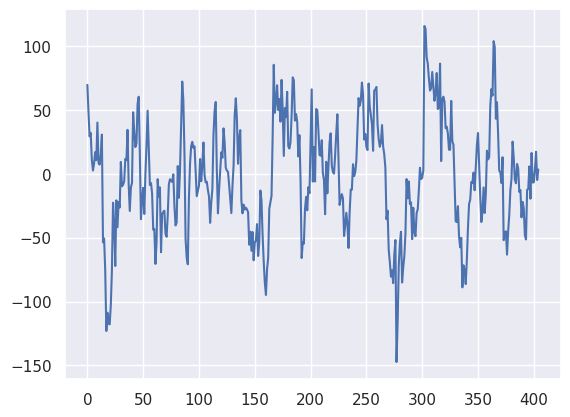

In [128]:
# Graph the loss

window_size = 25
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[50:])

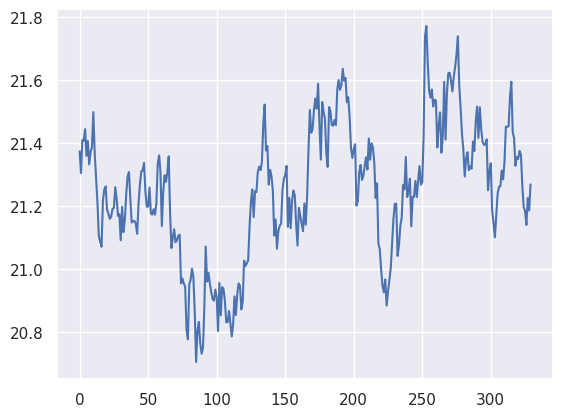

In [129]:
# Graph the rewards

window_size = 50
smoothed_rewards = []
for i in range(len(reward_history)-window_size):
  smoothed_rewards.append(np.mean(reward_history[i:i+window_size]))

plt.plot(smoothed_rewards[100:])

In [132]:
torch.save(model.state_dict(), reinforce_path)

In [94]:
test_sentence = test_dataset[0][input_lang]
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = target_lang,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: "We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.
Truncated input text: <id> "We now have 4-month-old mice that are non-diabetic that</s>


In [136]:
# Get test data
model.eval()
test_generator = get_data_generator(test_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size)
all_preds = []
all_refs = []

# Collect predictions and references
for input_batch, label_batch in test_generator:
    with torch.no_grad():
        model_out = model.generate(input_ids=input_batch)
    preds = tokenizer.batch_decode(model_out, skip_special_tokens=True)
    refs = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
    all_preds.extend(preds)
    all_refs.extend(refs)

# Store per-example scores
bleu_scores = []
rouge_scores = []
meteor_scores = []

for pred, ref in zip(all_preds, all_refs):
    # BLEU expects a list of references (even if it's just one)
    bleu = bleu_metric.compute(predictions=[pred], references=[[ref]])['score']
    rouge = rouge_metric.compute(predictions=[pred], references=[ref], rouge_types=["rougeL"], use_stemmer=True)['rougeL'] * 100
    meteor = meteor_metric.compute(predictions=[pred], references=[ref])['meteor'] * 100

    bleu_scores.append(bleu)
    rouge_scores.append(rouge)
    meteor_scores.append(meteor)

# Compute mean and standard deviation
print(f"BLEU Score: Mean = {np.mean(bleu_scores):.2f}, Std = {np.std(bleu_scores):.2f}, max = {np.max(bleu_scores):.2f}, min = {np.min(bleu_scores):.2f}")
print(f"ROUGE-L Score: Mean = {np.mean(rouge_scores):.2f}, Std = {np.std(rouge_scores):.2f}, max = {np.max(rouge_scores):.2f}, min = {np.min(rouge_scores):.2f}")
print(f"METEOR Score: Mean = {np.mean(meteor_scores):.2f}, Std = {np.std(meteor_scores):.2f}, max = {np.max(meteor_scores):.2f}, min = {np.min(meteor_scores):.2f}")

r_bleu_scores = bleu_scores[:]
r_rouge_scores = rouge_scores[:]
r_meteor_scores = meteor_scores[:]


BLEU Score: Mean = 17.69, Std = 15.66, max = 100.00, min = 0.00
ROUGE-L Score: Mean = 42.33, Std = 18.87, max = 100.00, min = 0.00
METEOR Score: Mean = 38.96, Std = 20.15, max = 99.99, min = 0.00


In [130]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

"dia -meh bahkan nya "M
"dia -meh bahkan nya tampak di itu lebih membaisih
"dia -meh bahkan nya "M a benar-diamanti yang


<ipython-input-142-9977b1956b6c>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_dict['data'], labels=stages, patch_artist=True,


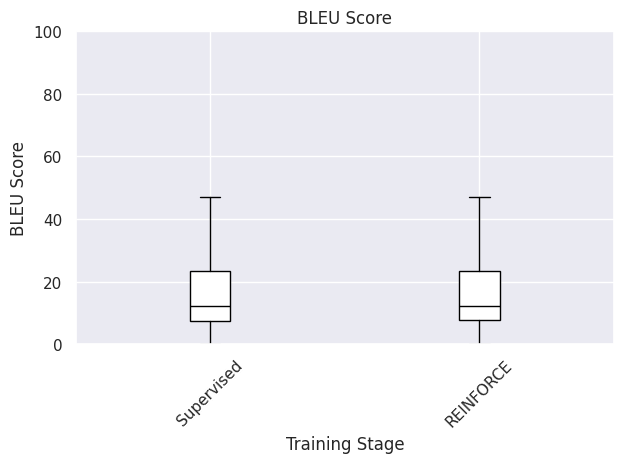

<ipython-input-142-9977b1956b6c>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_dict['data'], labels=stages, patch_artist=True,


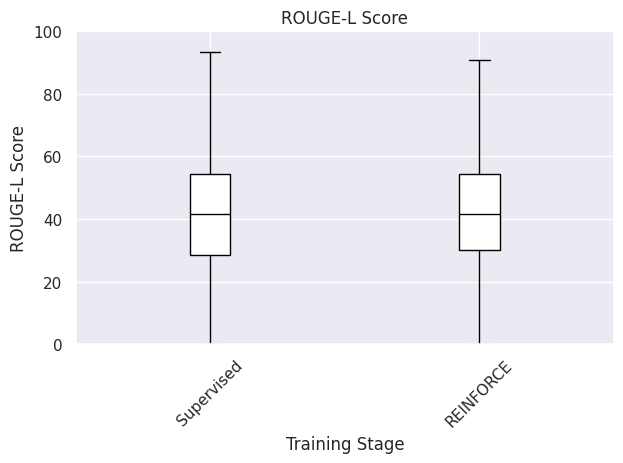

<ipython-input-142-9977b1956b6c>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_dict['data'], labels=stages, patch_artist=True,


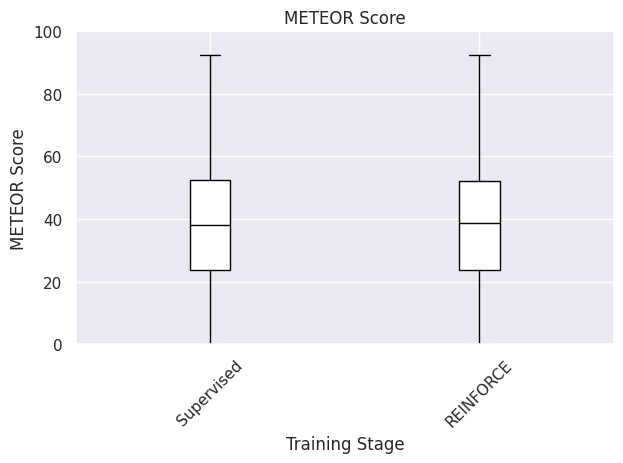

In [142]:
# Training stages
stages = ['Supervised', 'REINFORCE']

# Data for boxplots
metrics = {
    'BLEU Score': {'data': [
        s_bleu_scores,            # After Supervised
        r_bleu_scores             # After REINFORCE
    ]},
    'ROUGE-L Score': {'data': [
        s_rouge_scores,           # After Supervised
        r_rouge_scores            # After REINFORCE
    ]},
    'METEOR Score': {'data': [
        s_meteor_scores,          # After Supervised
        r_meteor_scores           # After REINFORCE
    ]}
}

# Plot boxplots
for metric, data_dict in metrics.items():
    plt.figure()
    plt.boxplot(data_dict['data'], labels=stages, patch_artist=True,
                boxprops=dict(facecolor='white', edgecolor='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='black'),
                flierprops=dict(markeredgecolor='black'),
                showfliers=False)
    plt.title(metric)
    plt.xlabel('Training Stage')
    plt.ylabel(metric)
    plt.ylim(0, 100)  # Keep y-axis limits
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()
    plt.show()